In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from numba import njit
from scipy.integrate import solve_ivp
import dask.dataframe as dd

In [2]:
df0 = pd.read_csv("df_output.csv")
df0

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,Phase_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A
0,92,623198111468628,43.898200,1.000000e-15,0.000186,75.23506,7,6,44.67820,26.748790,...,7,6,31.791800,8218.0870,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1
1,112,586465437076249,23.048440,1.000000e-15,0.000098,103.90500,7,6,26.01399,27.232310,...,7,6,30.988940,134.8864,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1
2,124,214297123674238,36.259980,1.000000e-15,0.000154,82.86009,7,6,43.63717,32.662180,...,7,6,37.747990,481.9433,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1
3,154,559548692536031,38.306070,1.000000e-15,0.000163,80.53965,7,6,86.13720,56.341010,...,7,6,57.456900,80356.4100,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1
4,180,424791614019654,17.229310,1.000000e-15,0.000073,120.21590,7,6,19.27244,17.397330,...,7,6,19.519880,109.5645,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230045,899694,430764938470682,8.034107,1.000000e-15,0.000034,176.19630,7,6,17.49480,6.209679,...,7,6,15.720420,2286.6000,0.247431,5.506292,2.000000e-10,4.623389e+12,0.0200,5.0
230046,899795,931971495385373,15.378850,1.000000e-15,0.000065,127.11050,7,6,100.42560,15.113400,...,7,6,96.932100,10003.8200,0.132846,3.315733,2.000000e-10,1.990603e+14,0.0200,5.0
230047,899879,158937381720381,14.039520,1.000000e-15,0.000060,133.04060,7,6,81.94600,1.235519,...,7,5,3.711674,433.0090,0.511304,13.406500,2.000000e-10,6.887031e+09,0.0200,5.0
230048,899888,161831677695017,4.364386,1.000000e-15,0.000019,238.61120,7,6,13.42219,1.235519,...,7,5,4.082497,349.3680,0.584510,12.611660,2.000000e-10,1.712514e+10,0.0200,5.0


In [3]:
n_rows_to_keep = 2500
df = df0[:n_rows_to_keep].copy()
df["Merge_time"] = np.nan
df

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time
0,92,623198111468628,43.89820,1.000000e-15,0.000186,75.23506,7,6,44.67820,26.748790,...,6,31.79180,8218.087000,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,NaN
1,112,586465437076249,23.04844,1.000000e-15,0.000098,103.90500,7,6,26.01399,27.232310,...,6,30.98894,134.886400,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,NaN
2,124,214297123674238,36.25998,1.000000e-15,0.000154,82.86009,7,6,43.63717,32.662180,...,6,37.74799,481.943300,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,NaN
3,154,559548692536031,38.30607,1.000000e-15,0.000163,80.53965,7,6,86.13720,56.341010,...,6,57.45690,80356.410000,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,NaN
4,180,424791614019654,17.22931,1.000000e-15,0.000073,120.21590,7,6,19.27244,17.397330,...,6,19.51988,109.564500,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,307400,853654194837765,26.39870,1.000000e-15,0.000112,97.08277,7,6,30.06574,24.200570,...,6,27.41962,119.958500,0.009882,4.655624,2.000000e-10,9.600316e+05,0.0002,0.1,NaN
2496,307427,611105804028612,35.83278,1.000000e-15,0.000152,83.27723,7,6,42.86181,35.568870,...,6,42.43849,20.214680,0.054350,3.655644,2.000000e-10,2.722543e+02,0.0002,0.1,NaN
2497,307455,930024133984856,37.94331,1.000000e-15,0.000161,80.93258,7,6,46.79656,7.321097,...,6,11.71306,20.846330,0.126676,7.137279,2.000000e-10,2.127762e+03,0.0002,0.1,NaN
2498,307474,376643106480511,38.95212,1.000000e-15,0.000165,79.88245,7,6,48.41524,21.209380,...,6,23.91973,4.569291,0.008311,5.641471,2.000000e-10,1.314544e+00,0.0002,0.1,NaN


In [4]:
G = 6.67e-11 / (6.96e8)**3 * 1.989e30 * (60*60*24*365*1e6)**2 #6.67*((6.96)**(-3))*1.989*((86400*365)**2)*1e7 #6.67e-11*(1/(6.96e8)**3)*1.989e30/((60*60*24*365*1e6)**2)
print(G)
c = 299792458 * 60*60*24*365*1e6 / 6.96e8 #299792458*86400*365*1e-2/6.96 #299792458*(1/6.96e8)*60*60*365*1e6
print(c)

3.913326754458976e+20
13583699648689.656


In [5]:
@njit
def f(t, x, b1, b2, b3, d1, d2) :
    y = np.zeros(2)
    y[0] = b1*(1+b2*x[1]**2+b3*x[1]**4)/((x[0]**3)*((1-x[1]**2)**3.5))
    y[1] = d1*x[1]*(1+d2*x[1]**2)/((x[0]**4)*((1-x[1]**2)**2.5))

    # se rimpiazzassi potenze intere con prodotti?
    # a, e = x # se no è un po' confuso (e forse smonto x troppe volte?)
    # y[0] = b1*(1+b2*e*e+b3*e*e*e*e)/((a*a*a)*((1-e*e)**3.5))
    # y[1] = d1*e*(1+d2*e*e)/((a*a*a*a)*((1-e*e)**2.5))

    # NO! La cella seguente si blocca per qualche motivo

    return y

T = 14e3

def merge_time(row) :
    a = row["Semimajor"].to_numpy()[0] #row[16] 
    e = row["Eccentricity"].to_numpy()[0] #row[17] 
    M = row["Mass_0"].to_numpy()[0] #row[2] 
    m = row["Mass_1"].to_numpy()[0] #row[9] 

    R = row["Radius_0"].to_numpy()[0] + row["Radius_1"].to_numpy()[0] #row[4] + row[11]

    t0 = row["BWorldtime"].to_numpy()[0] #row[18] 

    b0 = -(64/5)*G**3/c**5
    b1 = b0*M*m*(M+m)
    b2 = 73/24
    b3 = 37/96

    d0 = -(304/15)*G**3/c**5
    d1 = d0*M*m*(M+m)
    d2 = 121/304


    sol = solve_ivp(f, [t0,T], [a,e], method = "LSODA", args = (b1, b2, b3, d1, d2))#, min_step = 1e-11)

    x = sol.y[0]

    #row["Merge"]
    #row[21] = (x[(~np.isnan(x)) & (x > 0)].min() < R)
    v = np.diff(x, prepend = -x[0])
    #try :
    #    row[21] = sol.t[(~np.isnan(x)) & (x > 0) & (v < 0)][-1]
    #except :
    #    pass # soluzioni esattamente costanti danno un array vuoto!

    b = sol.t[(~np.isnan(x)) & (x > 0) & (v < 0)]
    if len(b) > 0 :
        row[21] = b[-1]

    #row[22] = sol.t[np.argmin(x[(~np.isnan(x)) & (x > 0)])]

    #return row
    return sol.t[np.argmin(x[(~np.isnan(x)) & (x > 0)])]

In [6]:
for index, subframe in tqdm(df.groupby(df.index)) :
    df.iloc[index, -1] = merge_time(subframe)

  0%|          | 1/2500 [00:00<21:24,  1.95it/s]C:\Users\ma_gi\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_ode.py:1352: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
100%|██████████| 2500/2500 [00:25<00:00, 98.74it/s] 


In [7]:
df

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time
0,92,623198111468628,43.89820,1.000000e-15,0.000186,75.23506,7,6,44.67820,26.748790,...,6,31.79180,8218.087000,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,14000.000000
1,112,586465437076249,23.04844,1.000000e-15,0.000098,103.90500,7,6,26.01399,27.232310,...,6,30.98894,134.886400,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,14000.000000
2,124,214297123674238,36.25998,1.000000e-15,0.000154,82.86009,7,6,43.63717,32.662180,...,6,37.74799,481.943300,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,14000.000000
3,154,559548692536031,38.30607,1.000000e-15,0.000163,80.53965,7,6,86.13720,56.341010,...,6,57.45690,80356.410000,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,14000.000000
4,180,424791614019654,17.22931,1.000000e-15,0.000073,120.21590,7,6,19.27244,17.397330,...,6,19.51988,109.564500,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,14000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,307400,853654194837765,26.39870,1.000000e-15,0.000112,97.08277,7,6,30.06574,24.200570,...,6,27.41962,119.958500,0.009882,4.655624,2.000000e-10,9.600316e+05,0.0002,0.1,14000.000000
2496,307427,611105804028612,35.83278,1.000000e-15,0.000152,83.27723,7,6,42.86181,35.568870,...,6,42.43849,20.214680,0.054350,3.655644,2.000000e-10,2.722543e+02,0.0002,0.1,274.227261
2497,307455,930024133984856,37.94331,1.000000e-15,0.000161,80.93258,7,6,46.79656,7.321097,...,6,11.71306,20.846330,0.126676,7.137279,2.000000e-10,2.127762e+03,0.0002,0.1,2116.785695
2498,307474,376643106480511,38.95212,1.000000e-15,0.000165,79.88245,7,6,48.41524,21.209380,...,6,23.91973,4.569291,0.008311,5.641471,2.000000e-10,1.314544e+00,0.0002,0.1,6.947659


In [8]:
df.iloc[26]["Merge_time"]

4770.879493681414

In [9]:
df.to_csv(f"df_con_Merge_time_{n_rows_to_keep}.csv")

In [10]:
isco = 6*G*(df.Mass_0 + df.Mass_1)/c**2
isco

0       0.000899
1       0.000640
2       0.000877
3       0.001204
4       0.000441
          ...   
2495    0.000644
2496    0.000909
2497    0.000576
2498    0.000766
2499    0.000877
Length: 2500, dtype: float64

In [78]:
R = df.Radius_0 + df.Radius_1
R

0       0.000300
1       0.000213
2       0.000292
3       0.000402
4       0.000147
          ...   
2495    0.000215
2496    0.000303
2497    0.000192
2498    0.000255
2499    0.000293
Length: 2500, dtype: float64

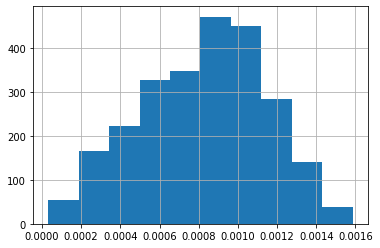

In [12]:
isco.hist();

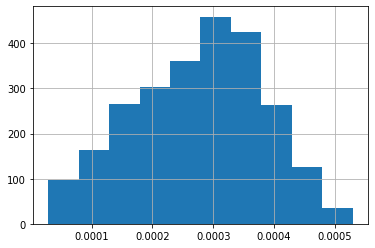

In [79]:
R.hist();

In [80]:
ratio = R/isco
ratio

0       0.333773
1       0.333553
2       0.333438
3       0.333774
4       0.333428
          ...   
2495    0.333541
2496    0.333756
2497    0.333712
2498    0.333701
2499    0.333773
Length: 2500, dtype: float64

In [81]:
print(ratio.mean(), ratio.std())

0.33712292980633457 0.02590250528081309


# Custom solver

In [16]:
@njit
def euler(t, x, dfdt, dt) :
    return x + dt*dfdt(t, x)

@njit
def euler2(t, x0, x1, dfdt, dt) :
    x = np.array([x0, x1])
    return x + dt*dfdt(t, x)

@njit
def midpoint(t, x, dfdt, dt) :
    return x + dt*dfdt(t+0.5*dt, x+0.5*dt*dfdt(t, x))

@njit
def midpoint2(t, x0, x1, dfdt, dt) :
    x = np.array([x0, x1])
    return x + dt*dfdt(t+0.5*dt, x+0.5*dt*dfdt(t, x))

In [17]:
#from functools import partial
#Df = partial(f, b0 = b0, b1 = b1, b2 = b2, b3 = b3, d0 = d0, d1 = d1, d2 = d2)

@njit
def f2(t, x) :
    y = np.zeros(2)
    y[0] = b1*(1+b2*x[1]**2+b3*x[1]**4)/((x[0]**3)*((1-x[1]**2)**3.5))
    y[1] = d1*x[1]*(1+d2*x[1]**2)/((x[0]**4)*((1-x[1]**2)**2.5))

    return y

In [18]:
a, e, t0, dt, M, m = df.iloc[26][["Semimajor", "Eccentricity", "BWorldtime", "GWtime", "Mass_0", "Mass_1"]].to_numpy()
b0 = -(64/5)*G**3/c**5
b1 = b0*M*m*(M+m)
b2 = 73/24
b3 = 37/96

d0 = -(304/15)*G**3/c**5
d1 = d0*M*m*(M+m)
d2 = 121/304

dt /= 10 #2
t = t0

a_end = isco.iloc[26]

max_iters = int(1e6)
tol = 1e-2 #1e-1 # non sembra esserci un calo significativo di prestazioni passando dal 10% all'1% di tolleranza; ciò che comanda pare essere max_iters
tol10 = tol/10
atol = tol*a_end
atol10 = atol/10

a_vec = -np.ones(max_iters)
e_vec = -np.ones(max_iters)
t_vec = -np.ones(max_iters)
dt_vec = -np.ones(max_iters)

a_vec[0] = a
e_vec[0] = e
t_vec[0] = t
dt_vec[0] = dt

In [19]:
a0, e0, dt0 = a, e, dt

In [20]:
@njit
def fn(t, a, e, dt, a_vec, e_vec, t_vec, dt_vec) : # se non passi tutti questi come argomenti numba impazzisce e si rifiuta di modificarli nel corpo della funzione
    for i in range(1, max_iters) :
        a1, e1 = midpoint(t, np.array([a, e]), f2, dt)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = midpoint(t, np.array([a, e]), f2, dt)
        a_vec[i], e_vec[i] = a, e = a1, e1
        #a, e = a1, e1
        #a_vec[i], e_vec[i] = a, e
        t += dt
        t_vec[i], dt_vec[i] = t, dt

In [21]:
@njit
def fn2(t, a, e, dt, a_vec, e_vec, t_vec, dt_vec) :
    for i in range(1, max_iters) :
        a1, e1 = midpoint2(t, a, e, f2, dt)
        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = midpoint2(t, a, e, f2, dt)
        a, e = a1, e1
        a_vec[i], e_vec[i] = a, e
        t += dt
        t_vec[i], dt_vec[i] = t, dt

In [22]:
%%timeit
fn(t, a, e, dt, a_vec, e_vec, t_vec, dt_vec)

796 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit 
fn2(t, a, e, dt, a_vec, e_vec, t_vec, dt_vec)

769 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
a_vec

array([8.59244200e+00, 8.55775982e+00, 8.52295407e+00, ...,
       2.80627580e-81, 2.80627580e-81, 2.80627580e-81])

In [25]:
a_end

9.725734526014496e-05

In [26]:
t_vec

array([  11.73906   ,   60.25838   ,  108.7777    , ..., 4795.33677613,
       4795.33677613, 4795.33677613])

In [27]:
dt_vec

array([485.1932 ,  48.51932,  48.51932, ...,   0.     ,   0.     ,
         0.     ])

In [28]:
@njit
def fn3(t, a, e, dt, a_vec, e_vec, t_vec, dt_vec) :
    a1, e1 = midpoint2(t, a, e, f2, dt)
    i = 1 
    
    if np.abs(a - a1) < a1*tol10 :
        dt *= 2
        a1, e1 = midpoint2(t, a, e, f2, dt)

    #while((np.abs(a1 - a_end) > 0.1) and (t < 14e3) and (i < max_iters)) :# qui abs è proprio necessario? meglio stare sicuri anche se forse può rallentare # 10% di distanza da a_end
    while (a1 > a_end) and (t < 14e3) and (i < max_iters) :
        a1, e1 = midpoint2(t, a, e, f2, dt)
        while np.abs(a - a1) > a1*tol :
            dt /= 10
            a1, e1 = midpoint2(t, a, e, f2, dt)
        a, e = a1, e1
        a_vec[i], e_vec[i] = a, e
        t += dt
        t_vec[i], dt_vec[i] = t, dt
        i += 1

In [29]:
%%time
fn3(t, a, e, dt, a_vec, e_vec, t_vec, dt_vec)

Wall time: 319 ms


In [30]:
print(a_vec[-1], a_end)

2.806275796077456e-81 9.725734526014496e-05


In [31]:
t_vec

array([  11.73906   ,   60.25838   ,  108.7777    , ..., 4795.33677613,
       4795.33677613, 4795.33677613])

In [32]:
dt_vec

array([485.1932 ,  48.51932,  48.51932, ...,   0.     ,   0.     ,
         0.     ])

In [33]:
@njit
def fn4_midpoint(t, a, e, dt) :
    for i in range(max_iters) :
        if (np.abs(a - a_end) < atol) or (t > 13.8e3) :
            break
        a1, e1 = midpoint2(t, a, e, f2, dt)

        if np.abs(a - a1) < a1*tol10 :
            dt *= 2
            a1, e1 = midpoint2(t, a, e, f2, dt)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = midpoint2(t, a, e, f2, dt)

        a, e = a1, e1
        t += dt
    return t, a, e, dt

In [34]:
%%timeit
a, e, t, dt = a0, e0, t0, dt0
t, a, e, dt = fn4_midpoint(t, a, e, dt)

2.61 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
print(f"a = {a}, a_end = {a_end}, t = {t}, np.abs(a - a_end) < atol = {np.abs(a - a_end) < atol}")

a = 8.592442, a_end = 9.725734526014496e-05, t = 11.73906, np.abs(a - a_end) < atol = False


In [36]:
@njit
def fn4_euler(t, a, e, dt) :
    for i in range(max_iters) :
        if (np.abs(a - a_end) < atol) or (t > 13.8e3) :
            break
        a1, e1 = euler2(t, a, e, f2, dt)

        if np.abs(a - a1) < a1*tol10 :
            dt *= 2
            a1, e1 = euler2(t, a, e, f2, dt)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = euler2(t, a, e, f2, dt)

        a, e = a1, e1
        t += dt
    return t, a, e, dt

In [37]:
%%timeit
a, e, t, dt = a0, e0, t0, dt0
t, a, e, dt = fn4_euler(t, a, e, dt)

1.52 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
print(f"a = {a}, a_end = {a_end}, t = {t}, np.abs(a - a_end) < atol = {np.abs(a - a_end) < atol}")

a = 8.592442, a_end = 9.725734526014496e-05, t = 11.73906, np.abs(a - a_end) < atol = False


# RK4

In [39]:
@njit
def rk42(t, x0, x1, dfdt, dt) :
    x = np.array([x0, x1])
    c1 = dfdt(t, x)
    c2 = dfdt(t+0.5*dt, x+0.5*c1)
    c3 = dfdt(t+0.5*dt, x+0.5*c2)
    c4 = dfdt(t+dt, x+dt*c3)

    return x + dt*(c1+2*c2+2*c3+c4)/6

In [40]:
@njit
def fn4_rk4(t, a, e, dt) :
    for i in range(max_iters) :
        if (np.abs(a - a_end) < atol) or (t > 13.8e3) :
            break
        a1, e1 = rk42(t, a, e, f2, dt)

        if np.abs(a - a1) < a1*tol10 :
            dt *= 2
            a1, e1 = rk42(t, a, e, f2, dt)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = rk42(t, a, e, f2, dt)

        a, e = a1, e1
        t += dt
    return t, a, e, dt

In [41]:
%%timeit
a, e, t, dt = a0, e0, t0, dt0
t, a, e, dt = fn4_rk4(t, a, e, dt)

1.02 s ± 41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
print(f"a = {a}, a_end = {a_end}, t = {t}, np.abs(a - a_end) < atol = {np.abs(a - a_end) < atol}")

a = 8.592442, a_end = 9.725734526014496e-05, t = 11.73906, np.abs(a - a_end) < atol = False


# RICORDA: t ESPLICITO NON SERVE!
è lì solo per ragioni "storiche", cioè la copia della f di `solve_ivp`

# Dataframe
NOTA: una volta compilata la funzione di numba i valori delle costanti nascosti al suo interno sono bloccati una tantum, ergo bisogna fondere le due funzioni (il che non è necessariamente un male se così facendo riduco il numero di chiamate)

ALTERNATIVA: passale come argomenti, probabilmente è più semplice. Se no bisogna ridefinire la funziona ogni volta dentro la funzione stessa (e forse è più lento, ma non ho voglia di provarlo).
Piano: fondere f/f2 con euler/midpoint/rk4/ ecc.

NOTA: in effetti va bene lasciare stare le funzioni Eulero ecc. e semplicemente usare f anziché f2 come dfdt; unica modifica: aggiungere le costanti come argomenti nelle rk4 ecc.

In [43]:
@njit 
def obtain_constants(row) :
    a = row[16] #row["Semimajor"]
    e = row[17] #row["Eccentricity"]
    M = row[2] #row["Mass_0"]
    m = row[9] #row["Mass_1"]

    t0 = row[18] #row["BWorldtime"]
    dt = row[20] #row["GWorldtime"]

    b0 = -(64/5)*G**3/c**5
    b1 = b0*M*m*(M+m)
    b2 = 73/24
    b3 = 37/96

    d0 = -(304/15)*G**3/c**5
    d1 = d0*M*m*(M+m)
    d2 = 121/304

    return a, e, t0, dt, b1, b2, b3, d1, d2

@njit
def f3(x, b1, b2, b3, d1, d2) :
    y = np.zeros(2)
    y[0] = b1*(1+b2*x[1]**2+b3*x[1]**4)/((x[0]**3)*((1-x[1]**2)**3.5))
    y[1] = d1*x[1]*(1+d2*x[1]**2)/((x[0]**4)*((1-x[1]**2)**2.5))

    return y

@njit
def euler3(x0, x1, dfdt, dt, b1, b2, b3, d1, d2) :
    x = np.array([x0, x1])
    return x + dt*dfdt(x, b1, b2, b3, d1, d2)


@njit
def midpoint3(x0, x1, dfdt, dt, b1, b2, b3, d1, d2) :
    x = np.array([x0, x1])
    return x + dt*dfdt(x+0.5*dt*dfdt(x, b1, b2, b3, d1, d2), b1, b2, b3, d1, d2)

@njit
def rk43(x0, x1, dfdt, dt, b1, b2, b3, d1, d2) :
    x = np.array([x0, x1])
    c1 = dfdt( x, b1, b2, b3, d1, d2)
    c2 = dfdt(x+0.5*c1, b1, b2, b3, d1, d2)
    c3 = dfdt(x+0.5*c2, b1, b2, b3, d1, d2)
    c4 = dfdt(x+dt*c3, b1, b2, b3, d1, d2)

    return x + dt*(c1+2*c2+2*c3+c4)/6

@njit
def eu(row) :
    a, e, t, dt, b1, b2, b3, d1, d2 = obtain_constants(row)
    for i in range(max_iters) :
        if (np.abs(a - a_end) < atol) or (t > 13.8e3) :
            break
        a1, e1 = euler3(a, e, f3, dt, b1, b2, b3, d1, d2)

        if np.abs(a - a1) < a1*tol10 :
            dt *= 2
            a1, e1 = euler3(a, e, f3, dt, b1, b2, b3, d1, d2)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = euler3(a, e, f3, dt, b1, b2, b3, d1, d2)

        a, e = a1, e1
        t += dt
    row[-1] = t
    return row

@njit
def mid(row) :
    a, e, t, dt, b1, b2, b3, d1, d2 = obtain_constants(row)
    for i in range(max_iters) :
        if (np.abs(a - a_end) < atol) or (t > 13.8e3) :
            break
        a1, e1 = midpoint3(a, e, f3, dt, b1, b2, b3, d1, d2)

        if np.abs(a - a1) < a1*tol10 :
            dt *= 2
            a1, e1 = midpoint3(a, e, f3, dt, b1, b2, b3, d1, d2)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = midpoint3(a, e, f3, dt, b1, b2, b3, d1, d2)

        a, e = a1, e1
        t += dt
    row[-1] = t
    return row

@njit
def rk(row) :
    a, e, t, dt, b1, b2, b3, d1, d2 = obtain_constants(row)
    for i in range(max_iters) :
        if (np.abs(a - a_end) < atol) or (t > 13.8e3) :
            break
        a1, e1 = rk43(a, e, f3, dt, b1, b2, b3, d1, d2)

        if np.abs(a - a1) < a1*tol10 :
            dt *= 2
            a1, e1 = rk43(a, e, f3, dt, b1, b2, b3, d1, d2)

        while(np.abs(a - a1) > a1*tol) :
            dt /= 10
            a1, e1 = rk43(a, e, f3, dt, b1, b2, b3, d1, d2)

        a, e = a1, e1
        t += dt
    row[-1] = t
    return row

In [44]:
df_eu = df.copy()
df_mid = df.copy() 
df_rk = df.copy()

df_eu["Merge_time_euler"] = np.nan
df_mid["Merge_time_midpoint"] = np.nan
df_rk["Merge_time_rk4"] = np.nan

In [45]:
%%time
df_eu = df_eu.apply(eu, axis = 1, raw = True)

Wall time: 989 ms


In [46]:
%%time
df_mid = df_mid.apply(mid, axis = 1, raw = True)

Wall time: 899 ms


In [47]:
%%time
df_rk = df_rk.apply(rk, axis = 1, raw = True)

Wall time: 3min 10s


In [48]:
df_eu

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time,Merge_time_euler
0,92.0,6.231981e+14,43.89820,1.000000e-15,0.000186,75.23506,7.0,6.0,44.67820,26.748790,...,31.79180,8218.087000,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,14000.000000,6.382553e+07
1,112.0,5.864654e+14,23.04844,1.000000e-15,0.000098,103.90500,7.0,6.0,26.01399,27.232310,...,30.98894,134.886400,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,14000.000000,1.572513e+04
2,124.0,2.142971e+14,36.25998,1.000000e-15,0.000154,82.86009,7.0,6.0,43.63717,32.662180,...,37.74799,481.943300,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,14000.000000,9.903227e+05
3,154.0,5.595487e+14,38.30607,1.000000e-15,0.000163,80.53965,7.0,6.0,86.13720,56.341010,...,57.45690,80356.410000,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,14000.000000,2.963007e+14
4,180.0,4.247916e+14,17.22931,1.000000e-15,0.000073,120.21590,7.0,6.0,19.27244,17.397330,...,19.51988,109.564500,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,14000.000000,2.080700e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,307400.0,8.536542e+14,26.39870,1.000000e-15,0.000112,97.08277,7.0,6.0,30.06574,24.200570,...,27.41962,119.958500,0.009882,4.655624,2.000000e-10,9.600316e+05,0.0002,0.1,14000.000000,1.920529e+04
2496,307427.0,6.111058e+14,35.83278,1.000000e-15,0.000152,83.27723,7.0,6.0,42.86181,35.568870,...,42.43849,20.214680,0.054350,3.655644,2.000000e-10,2.722543e+02,0.0002,0.1,274.227261,2.789087e+02
2497,307455.0,9.300241e+14,37.94331,1.000000e-15,0.000161,80.93258,7.0,6.0,46.79656,7.321097,...,11.71306,20.846330,0.126676,7.137279,2.000000e-10,2.127762e+03,0.0002,0.1,2116.785695,2.153968e+03
2498,307474.0,3.766431e+14,38.95212,1.000000e-15,0.000165,79.88245,7.0,6.0,48.41524,21.209380,...,23.91973,4.569291,0.008311,5.641471,2.000000e-10,1.314544e+00,0.0002,0.1,6.947659,6.971115e+00


In [49]:
df_mid

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time,Merge_time_midpoint
0,92.0,6.231981e+14,43.89820,1.000000e-15,0.000186,75.23506,7.0,6.0,44.67820,26.748790,...,31.79180,8218.087000,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,14000.000000,6.382553e+07
1,112.0,5.864654e+14,23.04844,1.000000e-15,0.000098,103.90500,7.0,6.0,26.01399,27.232310,...,30.98894,134.886400,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,14000.000000,1.572513e+04
2,124.0,2.142971e+14,36.25998,1.000000e-15,0.000154,82.86009,7.0,6.0,43.63717,32.662180,...,37.74799,481.943300,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,14000.000000,9.903227e+05
3,154.0,5.595487e+14,38.30607,1.000000e-15,0.000163,80.53965,7.0,6.0,86.13720,56.341010,...,57.45690,80356.410000,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,14000.000000,2.963007e+14
4,180.0,4.247916e+14,17.22931,1.000000e-15,0.000073,120.21590,7.0,6.0,19.27244,17.397330,...,19.51988,109.564500,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,14000.000000,2.080700e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,307400.0,8.536542e+14,26.39870,1.000000e-15,0.000112,97.08277,7.0,6.0,30.06574,24.200570,...,27.41962,119.958500,0.009882,4.655624,2.000000e-10,9.600316e+05,0.0002,0.1,14000.000000,1.920529e+04
2496,307427.0,6.111058e+14,35.83278,1.000000e-15,0.000152,83.27723,7.0,6.0,42.86181,35.568870,...,42.43849,20.214680,0.054350,3.655644,2.000000e-10,2.722543e+02,0.0002,0.1,274.227261,2.772583e+02
2497,307455.0,9.300241e+14,37.94331,1.000000e-15,0.000161,80.93258,7.0,6.0,46.79656,7.321097,...,11.71306,20.846330,0.126676,7.137279,2.000000e-10,2.127762e+03,0.0002,0.1,2116.785695,2.141337e+03
2498,307474.0,3.766431e+14,38.95212,1.000000e-15,0.000165,79.88245,7.0,6.0,48.41524,21.209380,...,23.91973,4.569291,0.008311,5.641471,2.000000e-10,1.314544e+00,0.0002,0.1,6.947659,6.963101e+00


In [50]:
df_rk

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time,Merge_time_rk4
0,92.0,6.231981e+14,43.89820,1.000000e-15,0.000186,75.23506,7.0,6.0,44.67820,26.748790,...,31.79180,8218.087000,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,14000.000000,6.382553e+07
1,112.0,5.864654e+14,23.04844,1.000000e-15,0.000098,103.90500,7.0,6.0,26.01399,27.232310,...,30.98894,134.886400,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,14000.000000,1.572513e+04
2,124.0,2.142971e+14,36.25998,1.000000e-15,0.000154,82.86009,7.0,6.0,43.63717,32.662180,...,37.74799,481.943300,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,14000.000000,9.903227e+05
3,154.0,5.595487e+14,38.30607,1.000000e-15,0.000163,80.53965,7.0,6.0,86.13720,56.341010,...,57.45690,80356.410000,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,14000.000000,2.963007e+14
4,180.0,4.247916e+14,17.22931,1.000000e-15,0.000073,120.21590,7.0,6.0,19.27244,17.397330,...,19.51988,109.564500,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,14000.000000,2.080700e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,307400.0,8.536542e+14,26.39870,1.000000e-15,0.000112,97.08277,7.0,6.0,30.06574,24.200570,...,27.41962,119.958500,0.009882,4.655624,2.000000e-10,9.600316e+05,0.0002,0.1,14000.000000,1.920529e+04
2496,307427.0,6.111058e+14,35.83278,1.000000e-15,0.000152,83.27723,7.0,6.0,42.86181,35.568870,...,42.43849,20.214680,0.054350,3.655644,2.000000e-10,2.722543e+02,0.0002,0.1,274.227261,2.761939e+02
2497,307455.0,9.300241e+14,37.94331,1.000000e-15,0.000161,80.93258,7.0,6.0,46.79656,7.321097,...,11.71306,20.846330,0.126676,7.137279,2.000000e-10,2.127762e+03,0.0002,0.1,2116.785695,2.164539e+03
2498,307474.0,3.766431e+14,38.95212,1.000000e-15,0.000165,79.88245,7.0,6.0,48.41524,21.209380,...,23.91973,4.569291,0.008311,5.641471,2.000000e-10,1.314544e+00,0.0002,0.1,6.947659,6.156906e+00


In [51]:
# df_eu.to_csv(f"df_eu_{n_rows_to_keep}.csv")
# df_mid.to_csv(f"df_mid_{n_rows_to_keep}.csv")
# df_rk.to_csv(f"df_rk_{n_rows_to_keep}.csv")

In [52]:
print(df_eu.iloc[26, -1], df_mid.iloc[26, -1], df_rk.iloc[26, -1])

4810.62655781489 4795.336799033888 4802.683635092978


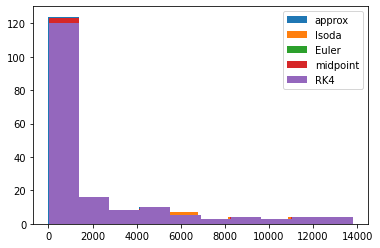

In [53]:
mask = df.GWtime < 14e3
plt.hist(df[mask].GWtime, label = "approx")
plt.hist(df[mask].Merge_time, label = "lsoda")
plt.hist(df_eu[mask].Merge_time_euler, label = "Euler")
plt.hist(df_mid[mask].Merge_time_midpoint, label = "midpoint")
plt.hist(df_rk[mask].Merge_time_rk4, label = "RK4");
plt.legend(loc = "best");

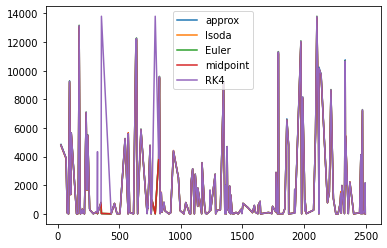

In [54]:
mask = df.GWtime < 14e3
plt.plot(df[mask].GWtime, label = "approx")
plt.plot(df[mask].Merge_time, label = "lsoda")
plt.plot(df_eu[mask].Merge_time_euler, label = "Euler")
plt.plot(df_mid[mask].Merge_time_midpoint, label = "midpoint")
plt.plot(df_rk[mask].Merge_time_rk4, label = "RK4")
plt.legend(loc = "best");

In [55]:
df.loc[mask, "Merge_time"]

26      4770.879494
68      3844.758753
77        79.790740
88         7.614393
96      9160.696048
           ...     
2475    7162.946640
2478      21.463295
2496     274.227261
2497    2116.785695
2498       6.947659
Name: Merge_time, Length: 177, dtype: float64

In [56]:
np.unique(df.loc[mask, "Z"])

array([0.0002])

In [57]:
np.unique(df.loc[mask, "A"]) # df è troppo piccolo, evidentemente

array([0.1])

In [58]:
print(np.unique(df0.loc[df0["GWtime"] < 14e3, "Z"]), np.unique(df0.loc[df0["GWtime"] < 14e3, "A"]))

[0.0002 0.002  0.02  ] [0.1 1.  5. ]


In [59]:
print(np.unique(df0["Z"]), np.unique(df0["A"])) # questo è già più utile

[0.0002 0.002  0.02  ] [0.1 1.  5. ]


# Dask
## *apply vs map_partitions*:
apply è parallelizzato ma è riga per riga, quindi è come ripartizionare con npartitions = n. righe, forse eccessivo; quindi in teoria è meglio map_partitions. Due difficoltà riguardo a quest'ultimo:
1) dentro una singola partizione è tutto sequenziale? Probabilmente, se no non ci sarebbe nessuna differenza con apply (credo). In ogni caso mentre apply passa alla funzione considerata solo una riga (come pd.Series o np.array) map_partitions passa più righe (quindi un dataframe sano), quindi serve a) una conversione ad un formato compatibile con numba (meno banale di `raw = True` in apply?), b) un ciclo for relativo alle righe/una vettorizzazione a colpi di `@numba.vectorize` - che però non so se contenga anche una compilazione JIT, ma probabilmente no (?)            

2) quante partizioni usiamo? Una best practice è ripartizionare con un numero di partizioni minore quando si riduce/filtra un dataframe; ho trovato 3 criteri:        
a) avere ogni partizione di circa 100 mb (impossibile in questo caso, tutto il dataframe interessante è < 50 mb);      
b) avere npartitions = 2*n threads disponibili (cioè tipicamente 4*n cores disponibili) per non lasciare nessun core inutilizzato (questo forse nel nostro caso comporta partizioni striminzite, però?)             
c) porre npartitions nuovo / npartitions vecchio = n righe dopo il filtro / n righe prima del filtro, cioè ridurre il numero di partizioni per lo stesso fattore per cui è stato ridotto il numero di righe del dataframe (forse la cosa più semplice? In ogni caso capirlo è non banale perché non so come giudicare se il numero di partizioni iniziale sia di per sé opportuno; ad esempio dask potrebbe porlo uguale al numero di csv letti... boh)                

## Approccio
La cosa più ovvia è provare tutte queste alternative e vedere cosa funziona meglio (noioso ma assolutamente anti ambiguo).        
Nota: visto che almeno con un dataframe ridotto Eulero/midpoint sono quasi istantanei potrebbero essere altrettanto veloci anche con tutto il dataset, quindi è opportuno non dare per scontato che dask batta pandas. Magari è uno dei casi in cui l'overhead non è più conveniente... Bisogna provare

Nota: i due gruppi di dati che leggiamo sul server (output*.csv e evolved*.dat) sono di 18018000 e 9009000 rispettivamente (output contiente due righe per ogni oggetto di evolved, i.e. inizio e fine); entrambi i dataset vengono di default partizionati in 180 parti da dask, e di conseguenza anche output filtrato (ridotto a 230050) ha npartitions = 180.

In [60]:
df1 = df0.copy()
df1["Merge_time_midpoint"] = np.nan 
df1

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time_midpoint
0,92,623198111468628,43.898200,1.000000e-15,0.000186,75.23506,7,6,44.67820,26.748790,...,6,31.791800,8218.0870,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,NaN
1,112,586465437076249,23.048440,1.000000e-15,0.000098,103.90500,7,6,26.01399,27.232310,...,6,30.988940,134.8864,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,NaN
2,124,214297123674238,36.259980,1.000000e-15,0.000154,82.86009,7,6,43.63717,32.662180,...,6,37.747990,481.9433,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,NaN
3,154,559548692536031,38.306070,1.000000e-15,0.000163,80.53965,7,6,86.13720,56.341010,...,6,57.456900,80356.4100,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,NaN
4,180,424791614019654,17.229310,1.000000e-15,0.000073,120.21590,7,6,19.27244,17.397330,...,6,19.519880,109.5645,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230045,899694,430764938470682,8.034107,1.000000e-15,0.000034,176.19630,7,6,17.49480,6.209679,...,6,15.720420,2286.6000,0.247431,5.506292,2.000000e-10,4.623389e+12,0.0200,5.0,NaN
230046,899795,931971495385373,15.378850,1.000000e-15,0.000065,127.11050,7,6,100.42560,15.113400,...,6,96.932100,10003.8200,0.132846,3.315733,2.000000e-10,1.990603e+14,0.0200,5.0,NaN
230047,899879,158937381720381,14.039520,1.000000e-15,0.000060,133.04060,7,6,81.94600,1.235519,...,5,3.711674,433.0090,0.511304,13.406500,2.000000e-10,6.887031e+09,0.0200,5.0,NaN
230048,899888,161831677695017,4.364386,1.000000e-15,0.000019,238.61120,7,6,13.42219,1.235519,...,5,4.082497,349.3680,0.584510,12.611660,2.000000e-10,1.712514e+10,0.0200,5.0,NaN


In [61]:
df1_dd = dd.from_pandas(df0, npartitions = 180) # in modo da replicare quanto c'è sul server di default

In [62]:
df1_dd["Merge_time_midpoint"] = np.nan 
df1_dd = df1_dd.apply(mid, axis = 1, raw = True, meta = df1_dd) # esattamente come con pandas puro

In [63]:
%%time
# pandas
df1 = df1.apply(mid, axis = 1, raw = True) # wall time di 1min 33s è perfettamente in linea con il fatto che se 2500 righe impiegano circa 1 secondo allora 230050 ne dovrebbero impiegare 230050/2500*1=92 secondi = 1 min 32 s

Wall time: 1min 28s


In [64]:
df1

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time_midpoint
0,92.0,6.231981e+14,43.898200,1.000000e-15,0.000186,75.23506,7.0,6.0,44.67820,26.748790,...,6.0,31.791800,8218.0870,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,6.382553e+07
1,112.0,5.864654e+14,23.048440,1.000000e-15,0.000098,103.90500,7.0,6.0,26.01399,27.232310,...,6.0,30.988940,134.8864,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,1.572513e+04
2,124.0,2.142971e+14,36.259980,1.000000e-15,0.000154,82.86009,7.0,6.0,43.63717,32.662180,...,6.0,37.747990,481.9433,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,9.903227e+05
3,154.0,5.595487e+14,38.306070,1.000000e-15,0.000163,80.53965,7.0,6.0,86.13720,56.341010,...,6.0,57.456900,80356.4100,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,2.963007e+14
4,180.0,4.247916e+14,17.229310,1.000000e-15,0.000073,120.21590,7.0,6.0,19.27244,17.397330,...,6.0,19.519880,109.5645,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,2.080700e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230045,899694.0,4.307649e+14,8.034107,1.000000e-15,0.000034,176.19630,7.0,6.0,17.49480,6.209679,...,6.0,15.720420,2286.6000,0.247431,5.506292,2.000000e-10,4.623389e+12,0.0200,5.0,4.623389e+10
230046,899795.0,9.319715e+14,15.378850,1.000000e-15,0.000065,127.11050,7.0,6.0,100.42560,15.113400,...,6.0,96.932100,10003.8200,0.132846,3.315733,2.000000e-10,1.990603e+14,0.0200,5.0,1.990603e+12
230047,899879.0,1.589374e+14,14.039520,1.000000e-15,0.000060,133.04060,7.0,6.0,81.94600,1.235519,...,5.0,3.711674,433.0090,0.511304,13.406500,2.000000e-10,6.887031e+09,0.0200,5.0,6.887032e+07
230048,899888.0,1.618317e+14,4.364386,1.000000e-15,0.000019,238.61120,7.0,6.0,13.42219,1.235519,...,5.0,4.082497,349.3680,0.584510,12.611660,2.000000e-10,1.712514e+10,0.0200,5.0,1.712514e+08


In [82]:
df1.to_csv("df1_mid.csv")

In [65]:
# pandas ma con Eulero
df1_eu = df0.copy()
df1_eu["Merge_time_euler"] = np.nan 

In [66]:
%%time
df1_eu = df1_eu.apply(eu, axis = 1, raw = True) # wall time di 1min 1s: più veloce di circa 30 secondi di midpoint (ragionevole: un po' più veloce ma non di troppo)

Wall time: 58.3 s


In [67]:
df1_eu

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time_euler
0,92.0,6.231981e+14,43.898200,1.000000e-15,0.000186,75.23506,7.0,6.0,44.67820,26.748790,...,6.0,31.791800,8218.0870,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,6.382553e+07
1,112.0,5.864654e+14,23.048440,1.000000e-15,0.000098,103.90500,7.0,6.0,26.01399,27.232310,...,6.0,30.988940,134.8864,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,1.572513e+04
2,124.0,2.142971e+14,36.259980,1.000000e-15,0.000154,82.86009,7.0,6.0,43.63717,32.662180,...,6.0,37.747990,481.9433,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,9.903227e+05
3,154.0,5.595487e+14,38.306070,1.000000e-15,0.000163,80.53965,7.0,6.0,86.13720,56.341010,...,6.0,57.456900,80356.4100,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,2.963007e+14
4,180.0,4.247916e+14,17.229310,1.000000e-15,0.000073,120.21590,7.0,6.0,19.27244,17.397330,...,6.0,19.519880,109.5645,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,2.080700e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230045,899694.0,4.307649e+14,8.034107,1.000000e-15,0.000034,176.19630,7.0,6.0,17.49480,6.209679,...,6.0,15.720420,2286.6000,0.247431,5.506292,2.000000e-10,4.623389e+12,0.0200,5.0,4.623389e+10
230046,899795.0,9.319715e+14,15.378850,1.000000e-15,0.000065,127.11050,7.0,6.0,100.42560,15.113400,...,6.0,96.932100,10003.8200,0.132846,3.315733,2.000000e-10,1.990603e+14,0.0200,5.0,1.990603e+12
230047,899879.0,1.589374e+14,14.039520,1.000000e-15,0.000060,133.04060,7.0,6.0,81.94600,1.235519,...,5.0,3.711674,433.0090,0.511304,13.406500,2.000000e-10,6.887031e+09,0.0200,5.0,6.887032e+07
230048,899888.0,1.618317e+14,4.364386,1.000000e-15,0.000019,238.61120,7.0,6.0,13.42219,1.235519,...,5.0,4.082497,349.3680,0.584510,12.611660,2.000000e-10,1.712514e+10,0.0200,5.0,1.712514e+08


In [68]:
%%time
# dask
df1_dd_computed = df1_dd.compute() # interessante, lo stesso identico wall time di 1min 33s..! Ma questo è solo apply, non è banale cosa accada con map partitions - che però per ora non ho voglia di implementare, ops

Wall time: 1min 32s


In [69]:
df1_dd_computed

,ID,name,Mass_0,Luminosity_0,Radius_0,Temperature_0,Phase_0,RemnantType_0,Zams_0,Mass_1,...,RemnantType_1,Zams_1,Semimajor,Eccentricity,BWorldtime,BTimestep,GWtime,Z,A,Merge_time_midpoint
0,92.0,6.231981e+14,43.898200,1.000000e-15,0.000186,75.23506,7.0,6.0,44.67820,26.748790,...,6.0,31.791800,8218.0870,0.933191,6.255643,2.000000e-10,6.382552e+09,0.0002,0.1,6.382553e+07
1,112.0,5.864654e+14,23.048440,1.000000e-15,0.000098,103.90500,7.0,6.0,26.01399,27.232310,...,6.0,30.988940,134.8864,0.009944,4.975206,2.000000e-10,1.572015e+06,0.0002,0.1,1.572513e+04
2,124.0,2.142971e+14,36.259980,1.000000e-15,0.000154,82.86009,7.0,6.0,43.63717,32.662180,...,6.0,37.747990,481.9433,0.012562,4.733170,2.000000e-10,9.903180e+07,0.0002,0.1,9.903227e+05
3,154.0,5.595487e+14,38.306070,1.000000e-15,0.000163,80.53965,7.0,6.0,86.13720,56.341010,...,6.0,57.456900,80356.4100,0.095792,4.171837,2.000000e-10,2.963007e+16,0.0002,0.1,2.963007e+14
4,180.0,4.247916e+14,17.229310,1.000000e-15,0.000073,120.21590,7.0,6.0,19.27244,17.397330,...,6.0,19.519880,109.5645,0.014440,6.984805,2.000000e-10,2.080002e+06,0.0002,0.1,2.080700e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230045,899694.0,4.307649e+14,8.034107,1.000000e-15,0.000034,176.19630,7.0,6.0,17.49480,6.209679,...,6.0,15.720420,2286.6000,0.247431,5.506292,2.000000e-10,4.623389e+12,0.0200,5.0,4.623389e+10
230046,899795.0,9.319715e+14,15.378850,1.000000e-15,0.000065,127.11050,7.0,6.0,100.42560,15.113400,...,6.0,96.932100,10003.8200,0.132846,3.315733,2.000000e-10,1.990603e+14,0.0200,5.0,1.990603e+12
230047,899879.0,1.589374e+14,14.039520,1.000000e-15,0.000060,133.04060,7.0,6.0,81.94600,1.235519,...,5.0,3.711674,433.0090,0.511304,13.406500,2.000000e-10,6.887031e+09,0.0200,5.0,6.887032e+07
230048,899888.0,1.618317e+14,4.364386,1.000000e-15,0.000019,238.61120,7.0,6.0,13.42219,1.235519,...,5.0,4.082497,349.3680,0.584510,12.611660,2.000000e-10,1.712514e+10,0.0200,5.0,1.712514e+08


# Statistiche
## ML con features = Z & A
*classification problem*: Fissato il punto $(Z,A)$ è fissata la predizione --> nessuna interpretazione probabilistica.       
*NN con softmax*: trucco, tanto vale usare p! Anche qui fissato Z ed A ed avendo accesso solo a queste informazioni realisticamente il meglio che la rete potrà fare è dare alle due categorie merge/non merge nel one hot encoding punteggi dati da p e 1-p di cui sotto        
*Generative models*: boh

## ML con features = ...
Così classification/prob. estimation con NN + softmax finale potrebbero dare effettivamente risultati non banali come sopra, ma è un problema diverso, da cui difficilmente districo Z e A dal resto (vista la incomprensibilità intrinseca di un modello di ML finito, arduo da interpretare)

## Bayes
*par. est.*: Z e A sicuramente influenzano il merge/non merge ma non in modo esclusivo; posso modellizzare merge/non merge come una var. random la cui distribuzione è parametrizzata da A e Z (che influenzano l'outcome). Se uso una verosimiglianza binomiale sto nascondendo la mancanza di conoscenza sugli altri parametri in un coin toss; ogni (Z,A) identifica un problema diverso dove la migliore stima di p con un prior uniforme è #merge/tot perché in questo caso ho posterior $\propto$ likelihood --> MAP bayesiano = MLE frequentista. Confrontare questi p è facile.     
*model comp./hyp. t.*: L'approccio di cui sopra non permette di unificare fin da subito (Z,A) diversi né è unico; si potrebbe imparare un modello parametrico/nonparametrico dai dati (con eventualmente hypothesis testing) per una verosimiglianza più realistica (?), ma brancoliamo nel buio           
**ANZI**: *non serve!* Infatti:       
a) non posso credere che per qualcosa di così complesso si riesca a costruire una serie di modelli sulla base di principi fisici       
b) costruire tante possibilità a sentimento non ha senso. Infatti anche se costruisci qualcosa di molto flessibile a quel punto stai solo facendo overfitting dei dati e costruendo qualcosa che non ha una interpretazione semplice (stessi problemi che affliggono le NN, quindi siamo punto e accapo).

## IT 
Forse la più semplice cosa non banale è usare la *mutual information* come matrice di covarianza potenziata per misurare quanto la conoscenza di Z e/o A permetta di determinare il valore della var. random merge/non merge!           
Note prese da sotto:            
1) Tutto sta nel costruire la matrice pmf rappresentante la joint dist., che sommata lungo le righe/colonne ci dà le due marginali; se queste preservano la forma (eventualmente le si constringe mediante reshape/ None o np.newaxis nel posto giusto) possiamo sfruttare il broadcasting per vettorizzare il calcolo della mutual information.                  
2) Ma come si interpreta il risultato? Bits e nats sono quantità astratte...

In [3]:
df1 = pd.read_csv("df1_mid.csv")

In [4]:
from itertools import product 

Z_values, A_values = np.unique(df0.Z), np.unique(df0.A)

In [5]:
ZA = list(product(Z_values, A_values))
print(ZA)

[(0.0002, 0.1), (0.0002, 1.0), (0.0002, 5.0), (0.002, 0.1), (0.002, 1.0), (0.002, 5.0), (0.02, 0.1), (0.02, 1.0), (0.02, 5.0)]


In [6]:
p = np.zeros(len(ZA))
df_merge = df1[df1.BWorldtime + df1.Merge_time_midpoint < 14e3]

for i, tup in enumerate(product(Z_values, A_values)) :
    Z, A = tup
    p[i] = len(df_merge[(df_merge.Z == Z) & (df_merge.A == A)])/len(df0[(df0.Z == Z) & (df0.A == A)])
    print(f"merge prob. for (Z,A) = {tup}: {p[i]}")

pmf = p.reshape(len(Z_values), len(A_values))
print("\n")
print(pmf)

merge prob. for (Z,A) = (0.0002, 0.1): 0.09953199573699087
merge prob. for (Z,A) = (0.0002, 1.0): 0.20433996383363473
merge prob. for (Z,A) = (0.0002, 5.0): 0.2751379550633746
merge prob. for (Z,A) = (0.002, 0.1): 0.07302809157252824
merge prob. for (Z,A) = (0.002, 1.0): 0.25460210586634197
merge prob. for (Z,A) = (0.002, 5.0): 0.2518483385877298
merge prob. for (Z,A) = (0.02, 0.1): 0.04192085093070546
merge prob. for (Z,A) = (0.02, 1.0): 0.027341854068920885
merge prob. for (Z,A) = (0.02, 5.0): 0.01709542204323169


[[0.099532   0.20433996 0.27513796]
 [0.07302809 0.25460211 0.25184834]
 [0.04192085 0.02734185 0.01709542]]


In [73]:
# # x = Z, y = A --> righe = A, colonne = Z
# X = np.array(ZA)[:,0].reshape((len(A_values), len(Z_values)))
# Y = np.array(ZA)[:,1].reshape((len(A_values), len(Z_values)))
# M = p.reshape((len(A_values), len(Z_values)))
# print(X)
# print(Y)
# print(M)

# è il contrario? In p fissare la riga significa fissare Z ecc.

In [74]:
import seaborn as sns

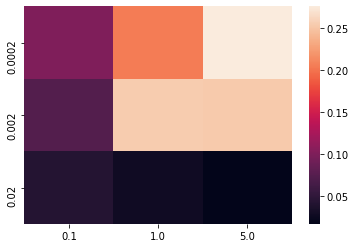

In [75]:
sns.heatmap(p.reshape((len(A_values), len(Z_values))), xticklabels = A_values, yticklabels = Z_values);

In [7]:
df_bool = df1[["Z", "A"]].copy()
df_bool["Merge"] = df1.BWorldtime + df1.Merge_time_midpoint < 14e3
df_bool

,Z,A,Merge
0,0.0002,0.1,False
1,0.0002,0.1,False
2,0.0002,0.1,False
3,0.0002,0.1,False
4,0.0002,0.1,False
...,...,...,...
230045,0.0200,5.0,False
230046,0.0200,5.0,False
230047,0.0200,5.0,False
230048,0.0200,5.0,False


In [77]:
# Tutto sta nel costruire la matrice pmf rappresentante la joint dist., che sommata lungo le righe/colonne ci dà le due marginali; se queste preservano la forma (eventualmente le si constringe mediante reshape/ None o np.newaxis nel posto giusto) possiamo sfruttare il broadcasting per vettorizzare il calcolo della mutual information.
# Ma come si interpreta il risultato? Bits e nats sono quantità astratte...

# Merge ha 2 valori, Z/A 3 --> se ad es. metto merge in y la pmf è una matrice 2x3

# Nota che la pmf cercata si può benissimo costruire dalla matrice p di cui sopra! Nota infatti che una delle due righe/colonne è 1 - l'altra, quindi ci basta trovare una riga/colonna di 3 elementi corrispondenti a tutti i Z per uno stesso A o viceversa. Al variare della variabile fissata ciò che mi interessa è quindi esattamente una delle 3 colonne/righe (posizione di questa colonna/riga determinata dalla variabile fissata). 

# RICORDA LA ASIMMETRIA DELLA MUTUAL INFORMATION COME CONSEGUENZA DI D_KL! In particolare noi vogliamo sapere cosa Z/A ci dice su merge, non il contrario